In [7]:
from pathlib import Path
import os
import pandas as pd
#!pip install TinyAutoML
from TinyAutoML.Estimator import MetaPipeline
from MyTools.add_AR_cols import add_AR_cols
from data_treatment.box_creator import create_binary_box
import TinyAutoML as tam

if not "root" in locals():
    current_path = Path(os.getcwd())
    root = current_path.parent.absolute()

os.chdir(root)

Here we import the whole cleaned dataset. It is 166 columns for 3692 rows.
We add Auto-lagged cols and the binary target

In [8]:
df = pd.read_csv('database.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = create_binary_box(df, relative_threshold = 0.20, box_length=30).set_index(['Date']).dropna(axis = 0)
df = add_AR_cols(df,7).dropna(axis = 0)
X,y = df.drop('Box', axis=1)[:'2020'], df['Box'][:'2020']

cut = int(len(y) * 0.8)

X_train, X_test = X[:cut], X[cut:]
y_train, y_test = y[:cut], y[cut:]

Then we instantiate the MetaPipeline object, we fit it and look at the outputs and scores.



In [10]:
mpipe = tam.Estimator.MetaPipeline(model='orfa',grid_search=True)
mpipe.fit(X_train,y_train)

INFO:root:Correcting non-stationarity on the dataset...
INFO:root:Selecting features according to LASSO logit regression
100%|██████████| 10/10 [00:02<00:00,  4.08it/s]
INFO:root:Training models...
INFO:root:	----> rfc
INFO:root:	----> Logistic Regression
INFO:root:	----> Gaussian Naive Bayes
INFO:root:	----> LDA


MetaPipeline()

In [11]:
#mpipe.get_scores()
mpipe.classification_report(X_test,y_test)

INFO:root:Correcting non-stationarity on the dataset...


              precision    recall  f1-score   support

           0       0.53      0.81      0.64       287
           1       0.79      0.50      0.61       416

    accuracy                           0.63       703
   macro avg       0.66      0.66      0.63       703
weighted avg       0.69      0.63      0.62       703



INFO:root:Correcting non-stationarity on the dataset...


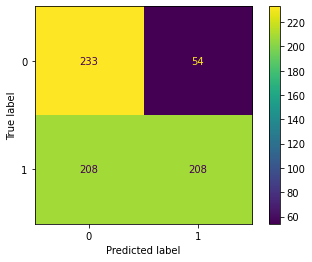

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test[17:],mpipe.predict(X_test))

INFO:root:Correcting non-stationarity on the dataset...


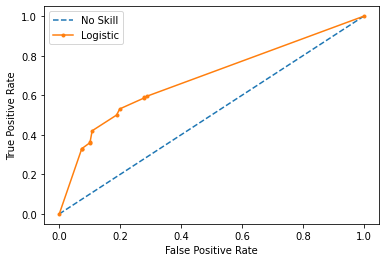

In [13]:
mpipe.roc_curve(X_test,y_test)

In [14]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test[17:],mpipe.predict(X_test))

INFO:root:Correcting non-stationarity on the dataset...


0.6273115220483642

AttributeError: 'RandomizedSearchCV' object has no attribute 'tree_'

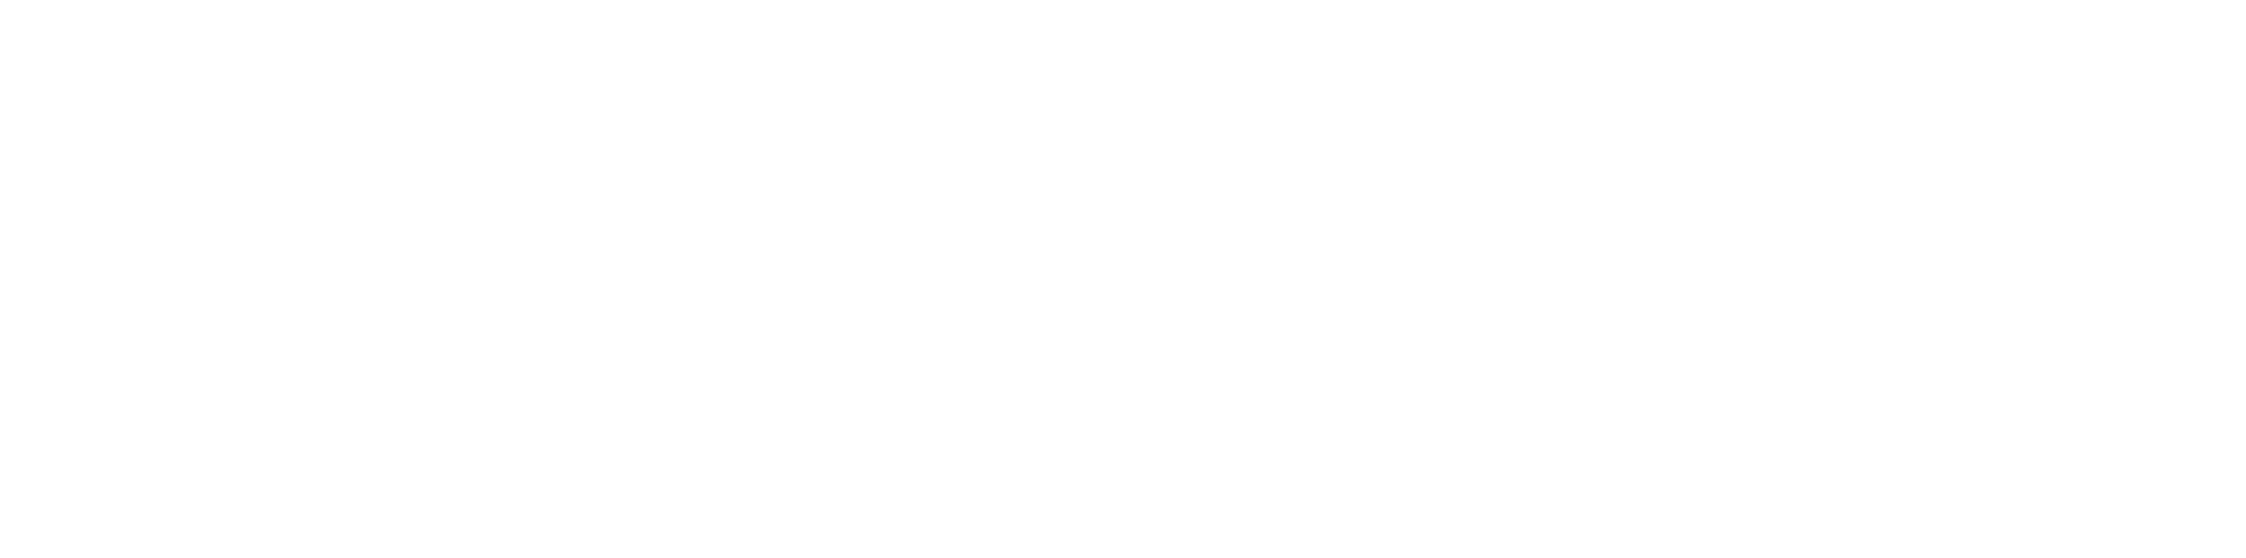

In [17]:
from matplotlib import pyplot as plt
from sklearn import tree


fig = plt.figure(figsize=(40,10))
_ = tree.plot_tree(mpipe.pipe.named_steps['ORFA'].ruler,
                   label='root',
                   class_names= ['not up', 'up'],
                   filled=True)

In [ ]:
import xgboost as xgb

clf = xgb.XGBClassifier(eval_metric='auc')
clf.fit(X_train,y_train)




In [ ]:
accuracy_score(y_test,clf.predict(X_test))
